In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.animation as animation
import glob, re, os
import pandas as pd

import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
# Don't use cuda
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


import scienceplots
plt.style.use('default')
plt.style.use(['science', 'high-vis', 'grid'])

2023-03-08 19:09:42.919065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 19:09:43.000181: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-08 19:09:43.002549: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/remi/software:
2023-03-08 19:09:43.002559: I tensorflow/compiler/xla/stream_executor/cud

In [2]:
def plot_loss(history, ax):
    """ Plot the loss function. """
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    ax.grid(True)

In [3]:
dataset_path = "../../build/DATASET/dataset_2023-03-08_18-25-08.csv"
df = pd.read_csv(dataset_path, sep=",", header=0)
df

,TotalLength,DonorLength,DonorLevel,AcceptorLevel,BreakdownVoltage,BreakdownProbability,DepletionWidth
0,9.888,1.712,3.743000e+18,3.113000e+14,186.832,0.434,8.054
1,5.289,0.391,1.270000e+14,2.490000e+17,NaN,0.000,0.424
2,5.416,2.919,9.889000e+18,2.511000e+15,68.637,0.560,2.430
3,5.363,1.350,6.287000e+19,6.358000e+18,6.515,0.718,0.040
4,9.975,0.744,1.035000e+15,2.090000e+19,24.197,0.763,0.625
...,...,...,...,...,...,...,...
2484,6.400,1.991,2.179000e+16,2.737000e+19,33.272,0.497,1.364
2485,6.595,3.471,8.224000e+19,8.118000e+18,6.980,0.734,0.033
2486,5.358,2.337,3.368000e+14,1.649000e+17,67.939,0.000,2.431
2487,8.035,1.351,2.006000e+19,2.886000e+15,124.477,0.327,6.565


In [4]:
# Drop NaN values
df = df.dropna()
df.tail()

# The DonorLevel and AcceptorLevel columns must be log10 transformed
df['DonorLevel'] = np.log10(df['DonorLevel'])
df['AcceptorLevel'] = np.log10(df['AcceptorLevel'])



/tmp/ipykernel_318846/2764885885.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DonorLevel'] = np.log10(df['DonorLevel'])
/tmp/ipykernel_318846/2764885885.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AcceptorLevel'] = np.log10(df['AcceptorLevel'])


## Neural network regression to learn BV from Total Length, Donor Length, Donor Level and Acceptor level.

In [5]:
# Neural network regression to learn BV from Total Length, Donor Length, Donor Level and Acceptor level.
# We will use the keras/TensorFlow library to build the neural network.

In [6]:
# Split the data into train and test sets
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)


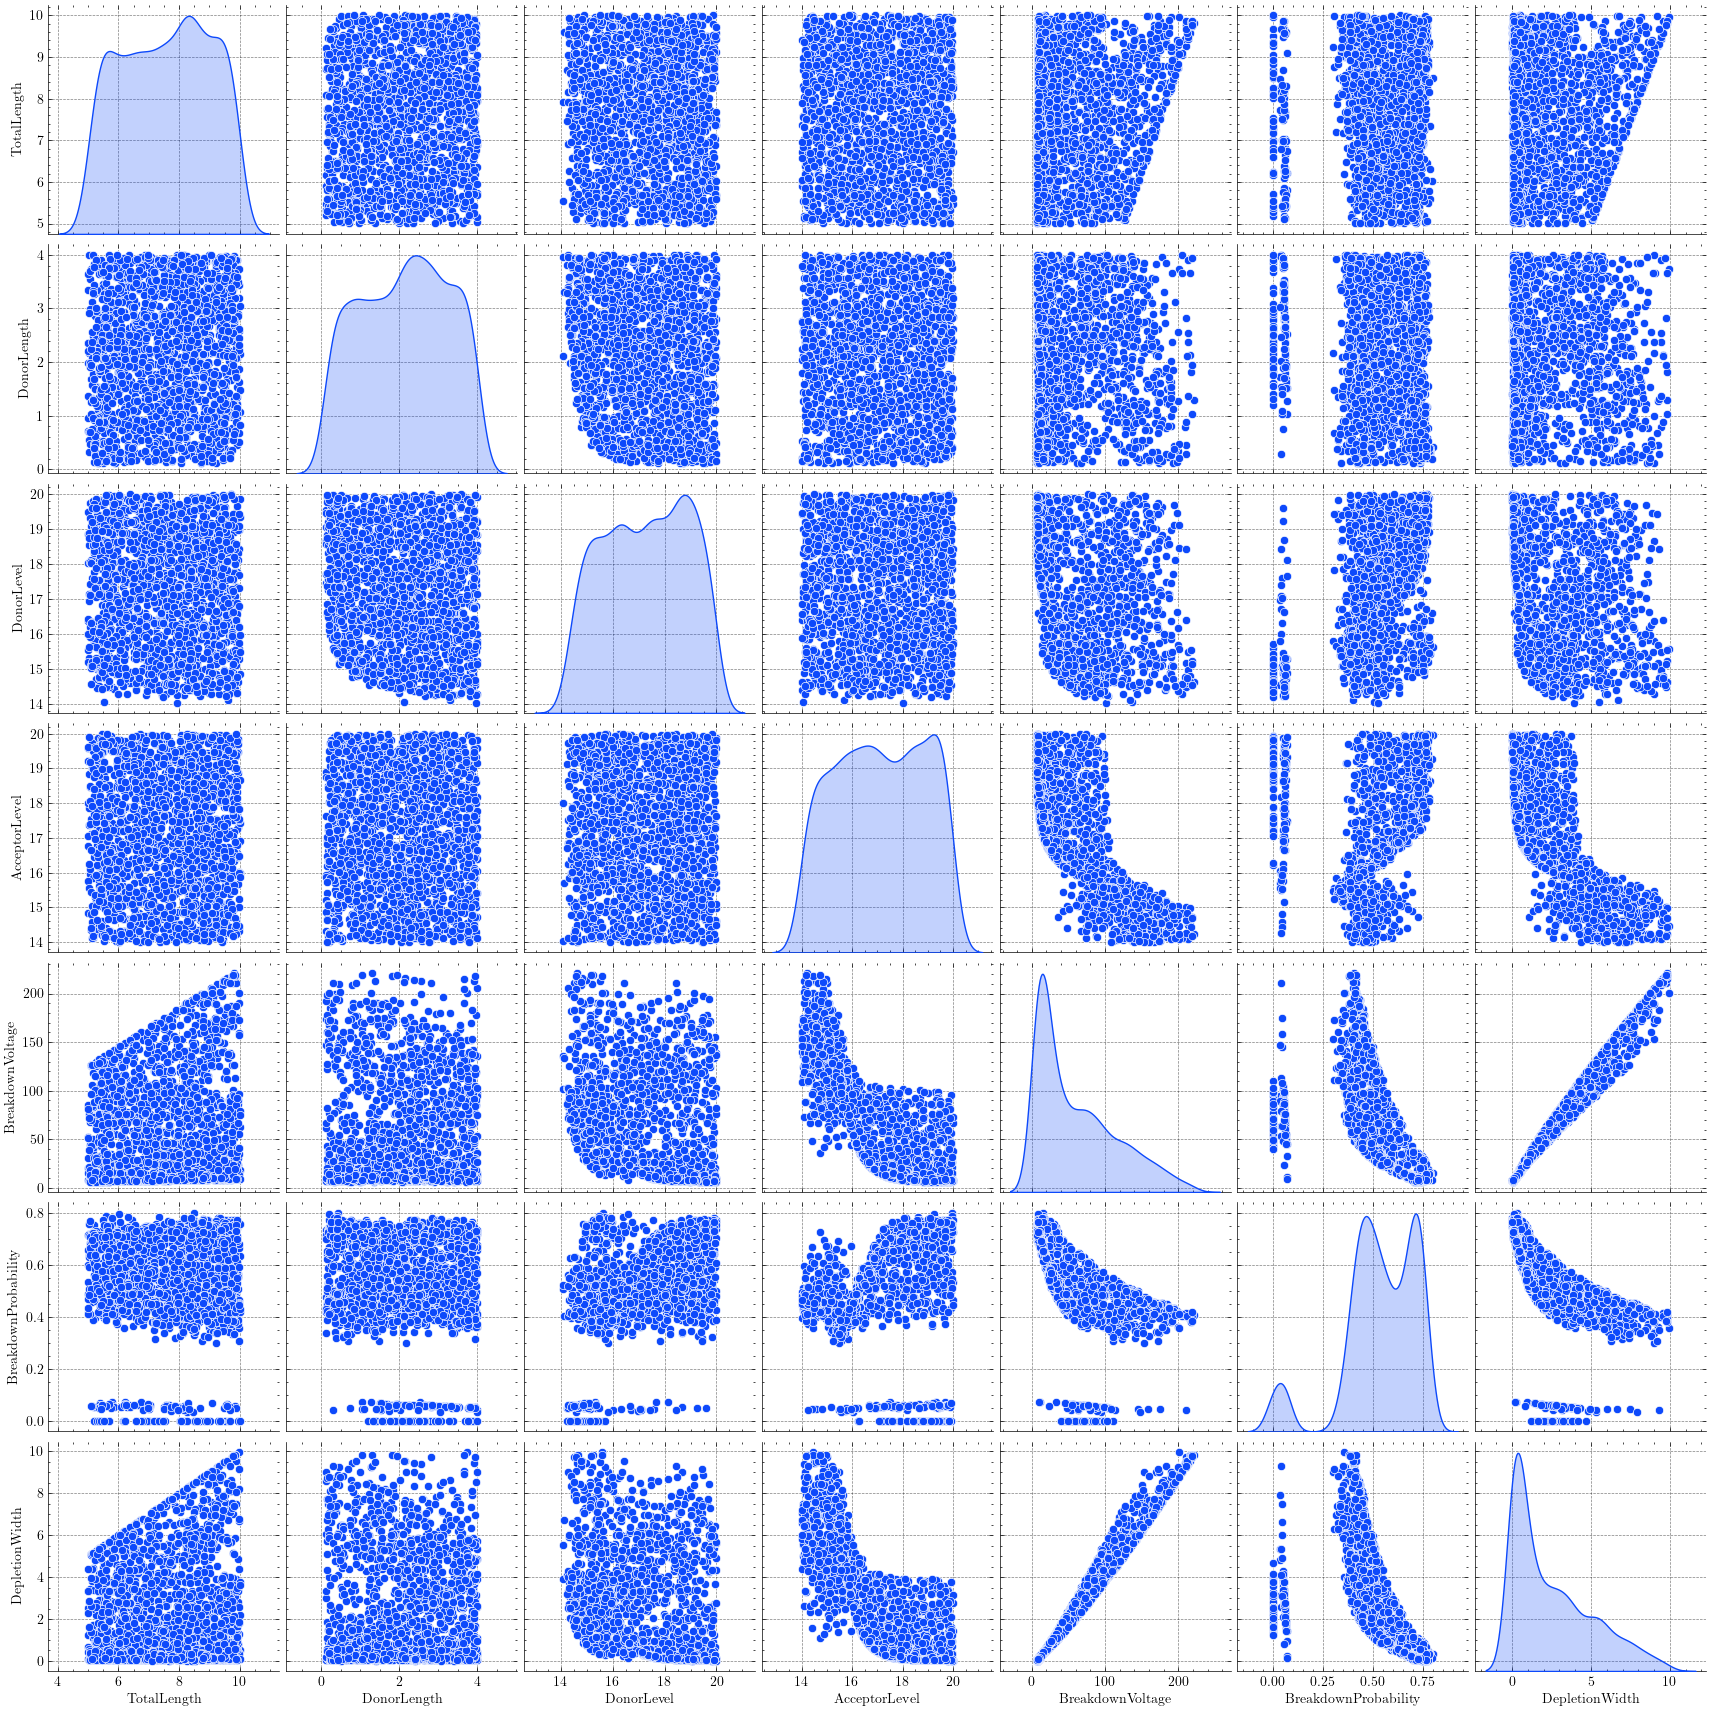

In [7]:
# Inspect the data
pp = sns.pairplot(train_dataset[["TotalLength", "DonorLength", "DonorLevel", "AcceptorLevel", "BreakdownVoltage", "BreakdownProbability", "DepletionWidth"]], diag_kind="kde")
plt.show()

In [8]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TotalLength,1791.0,7.572054,1.433992,5.002000,6.330000,7.640000,8.791000,10.000000
DonorLength,1791.0,2.118541,1.114768,0.116000,1.175500,2.182000,3.028000,4.000000
DonorLevel,1791.0,17.251826,1.612484,14.044932,15.880460,17.332236,18.645666,19.999652
AcceptorLevel,1791.0,17.111606,1.738225,14.003029,15.650016,17.117934,18.634427,19.996205
BreakdownVoltage,1791.0,60.926832,53.888282,6.515000,13.262000,43.123000,94.929000,220.802000
BreakdownProbability,1791.0,0.534776,0.185482,0.000000,0.446000,0.545000,0.693000,0.802000
DepletionWidth,1791.0,2.521090,2.518011,0.018000,0.304500,1.652000,4.088500,9.944000


In [9]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels_BV = train_features.pop('BreakdownVoltage')
test_labels_BV = test_features.pop('BreakdownVoltage')

train_labels_BrP = train_features.pop('BreakdownProbability')
test_labels_BrP = test_features.pop('BreakdownProbability')

train_labels_DW = train_features.pop('DepletionWidth')
test_labels_DW = test_features.pop('DepletionWidth')


In [10]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
TotalLength,7.572054,1.433992
DonorLength,2.118541,1.114768
DonorLevel,17.251826,1.612484
AcceptorLevel,17.111606,1.738225
BreakdownVoltage,60.926832,53.888282
BreakdownProbability,0.534776,0.185482
DepletionWidth,2.521090,2.518011


In [11]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())


2023-03-08 19:09:52.012963: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/remi/software:
2023-03-08 19:09:52.012999: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 19:09:52.013029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (RDevice): /proc/driver/nvidia/version does not exist
2023-03-08 19:09:52.013414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[ 7.5720553  2.118541  17.251827  17.111609 ]]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 14
Trainable params: 5
Non-trainable params: 9
_________________________________________________________________
1/1 [==============================] - 0s 55ms/step
Epoch 1/200
45/45 [==============================] - 0s 4ms/step - loss: 58.5687 - val_loss: 57.3163
Epoch 2/200
45/45 [==============================] - 0s 1ms/step - loss: 54.1352 - val_loss: 52.8759
Epoch 3/200
45/45 [==============================] - 0s 1ms/step - loss: 49.8498 - val_loss: 48.5120
Epoch 4/200
45/45 [=================

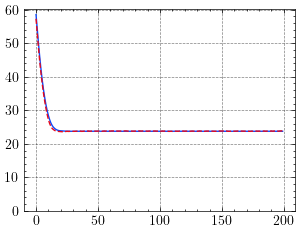

In [12]:
# First try with a simple linear model
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

linear_model.predict(train_features[:10])
linear_model.layers[1].kernel

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(
    train_features,
    train_labels_BV,
    epochs=200,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

fig, ax = plt.subplots()
plot_loss(history, ax)
ax.set_ylim(bottom=0.0)

plt.show()

In [24]:
# Regression with a deep neural network
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model



dnn_model_BV = build_and_compile_model(normalizer)
dnn_model_BV.summary()

history_BV = dnn_model_BV.fit(
    train_features, train_labels_BV,
    validation_split=0.2,
    verbose=1, epochs=250)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense_13 (Dense)            (None, 64)                320       
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                      

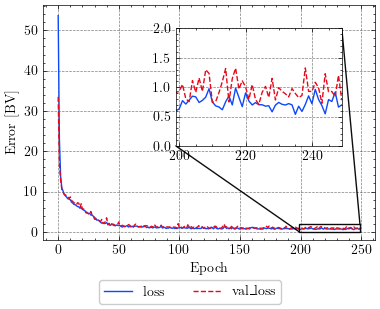

In [25]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_loss(history_BV, ax)
ax.set_ylim(bottom=-2.0)
# Inset zoom
axins = ax.inset_axes([0.4, 0.4, 0.5, 0.5])
plot_loss(history_BV, axins)
axins.set_xlim(history_BV.epoch[-1]-50, history_BV.epoch[-1])
axins.set_ylim(0.0, 2.0)
ax.indicate_inset_zoom(axins, edgecolor="k", alpha=0.95)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error [BV]')

fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.07), frameon=True, fancybox=True, shadow=False)
fig.tight_layout()
fig.savefig('BV_loss.pdf', bbox_inches='tight')
plt.show()

14/14 [==============================] - 0s 1ms/step


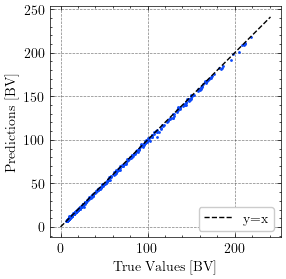

In [26]:
# Make predictions
test_predictions_BV = dnn_model.predict(test_features).flatten()

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(test_labels_BV, test_predictions_BV, s=1)
ax.set_xlabel('True Values [BV]')
ax.set_ylabel('Predictions [BV]')
ax.set_aspect('equal')
minmax_x = np.array([0, 1.1*np.max(test_labels_BV)])
ax.plot(minmax_x, minmax_x, color='k', linestyle='--', label='y=x')
ax.legend(loc='lower right')
plt.show()

In [27]:
history_BrP = dnn_model.fit(
    train_features, train_labels_BrP,
    validation_split=0.2,
    verbose=1, epochs=250)

Epoch 1/250
45/45 [==============================] - 0s 2ms/step - loss: 16.4645 - val_loss: 0.2339
Epoch 2/250
45/45 [==============================] - 0s 2ms/step - loss: 0.1259 - val_loss: 0.1143
Epoch 3/250
45/45 [==============================] - 0s 3ms/step - loss: 0.0937 - val_loss: 0.1049
Epoch 4/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0834 - val_loss: 0.0968
Epoch 5/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.0915
Epoch 6/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0742 - val_loss: 0.0884
Epoch 7/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0854
Epoch 8/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0839
Epoch 9/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0813
Epoch 10/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0653 - val_loss: 0.0785
Epoch 11

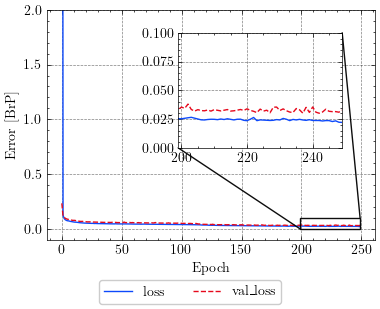

In [28]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_loss(history_BrP, ax)
ax.set_ylim(bottom=-0.10, top=2.0)
# Inset zoom
axins = ax.inset_axes([0.4, 0.4, 0.5, 0.5])
plot_loss(history_BrP, axins)
axins.set_xlim(history_BrP.epoch[-1]-50, history_BrP.epoch[-1])
axins.set_ylim(0.0, 0.10)
ax.indicate_inset_zoom(axins, edgecolor="k", alpha=0.95)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error [BrP]')

fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.07), frameon=True, fancybox=True, shadow=False)
fig.tight_layout()
fig.savefig('BV_loss.pdf', bbox_inches='tight')
plt.show()

14/14 [==============================] - 0s 940us/step


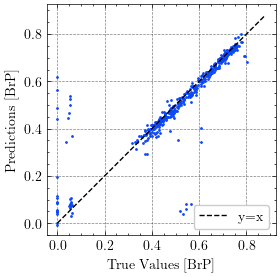

In [29]:
# Make predictions
test_predictions_BrP = dnn_model.predict(test_features).flatten()

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(test_labels_BrP, test_predictions_BrP, s=1)
ax.set_xlabel('True Values [BrP]')
ax.set_ylabel('Predictions [BrP]')
ax.set_aspect('equal')
minmax_x = np.array([0, 1.1*np.max(test_labels_BrP)])
ax.plot(minmax_x, minmax_x, color='k', linestyle='--', label='y=x')
ax.legend(loc='lower right')
plt.show()

In [30]:
history_DW = dnn_model.fit(
    train_features, train_labels_DW,
    validation_split=0.2,
    verbose=1, epochs=250)


Epoch 1/250
45/45 [==============================] - 0s 2ms/step - loss: 1.6676 - val_loss: 0.5357
Epoch 2/250
45/45 [==============================] - 0s 2ms/step - loss: 0.2620 - val_loss: 0.2662
Epoch 3/250
45/45 [==============================] - 0s 2ms/step - loss: 0.1460 - val_loss: 0.1534
Epoch 4/250
45/45 [==============================] - 0s 2ms/step - loss: 0.1367 - val_loss: 0.2053
Epoch 5/250
45/45 [==============================] - 0s 2ms/step - loss: 0.1238 - val_loss: 0.1106
Epoch 6/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0955 - val_loss: 0.0939
Epoch 7/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0838 - val_loss: 0.0870
Epoch 8/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0838
Epoch 9/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0800 - val_loss: 0.1031
Epoch 10/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0658 - val_loss: 0.0777
Epoch 11/

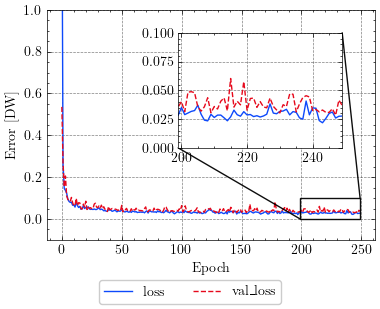

In [31]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_loss(history_DW, ax)
ax.set_ylim(bottom=-0.10, top=1.0)
# Inset zoom
axins = ax.inset_axes([0.4, 0.4, 0.5, 0.5])
plot_loss(history_DW, axins)
axins.set_xlim(history_DW.epoch[-1]-50, history_DW.epoch[-1])
axins.set_ylim(0.0, 0.1)
ax.indicate_inset_zoom(axins, edgecolor="k", alpha=0.95)
ax.set_xlabel('Epoch')
ax.set_ylabel('Error [DW]')

fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.07), frameon=True, fancybox=True, shadow=False)
fig.tight_layout()
fig.savefig('BV_loss.pdf', bbox_inches='tight')
plt.show()

14/14 [==============================] - 0s 831us/step


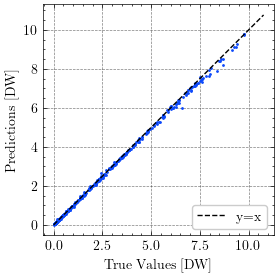

In [32]:
# Make predictions
test_predictions_DW = dnn_model.predict(test_features).flatten()

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(test_labels_DW, test_predictions_DW, s=1)
ax.set_xlabel('True Values [DW]')
ax.set_ylabel('Predictions [DW]')
ax.set_aspect('equal')
minmax_x = np.array([0, 1.1*np.max(test_labels_DW)])
ax.plot(minmax_x, minmax_x, color='k', linestyle='--', label='y=x')
ax.legend(loc='lower right')
plt.show()
